In [1]:
from data import *
from slam import *
from pr2_utils import *
from lidar import *
from helpers import *
from stereo import *
import glob
# Fast loading of data with PKL
pkl_file = open('data.pkl', 'rb')
data = pickle.load(pkl_file)
# slam = slam(1, (-300, 1400), (-1100, 800), 1)
slam = slam(1, (-200, 1300), (-1100, 100), 1, Nthresh = 2)
# Initial position
theta, x_pred, y_pred = 0, 0, 0
# noiseSigma = np.diag([5e-2, 5e-2, 5e-3])
noiseSigma = np.diag([5e-7, 5e-7, 5e-7])
# noiseSigma = np.diag([0, 0, 0])
# noiseSigma = np.diag([5, 5, 0.5])
lidar = lidar(slam.mapLogOdds)
# map = map
lidarInWorldParticles = np.empty((slam.numParticles,286,2))
pred=[]
trust = math.log(9)
logOddsLim = (-100, 100)
x_im = np.arange(slam.mapLogOdds.MAP['xmin'],slam.mapLogOdds.MAP['xmax']+slam.mapLogOdds.MAP['res'],slam.mapLogOdds.MAP['res']) #x-positions of each pixel of the map
y_im = np.arange(slam.mapLogOdds.MAP['ymin'],slam.mapLogOdds.MAP['ymax']+slam.mapLogOdds.MAP['res'],slam.mapLogOdds.MAP['res']) #x-positions of each pixel of the map
noise = np.zeros((slam.numParticles,3))
stereo = stereo()
lpics = glob.glob("data/stereo_images/stereo_left/*")
rpics = glob.glob("data/stereo_images/stereo_right/*")
for i in range(1, len(data.lidar_data[:,0])):

    # get lidar poiints
    lidarInV,  lidarInS= lidar.getLidarInV(data.lidar_data[i]) # 286 by 2
    if i==1:
        #build binary map
        lidarInW = Rotate2D(theta, lidarInV) + np.array([x_pred,y_pred])
        lidarInM = slam.mapLogOdds.coordToMap(lidarInW)
        slam.mapLogOdds.MAP['map'][lidarInM[0], lidarInM[1]]=1

    # Differential Drive Prediction
    time_diff1 = (data.encoder_timestamp[i] - data.encoder_timestamp[i-1])*(10**(-9))
    left_velocity, right_velocity = (data.left_meters[i]-data.left_meters[i-1])/(time_diff1) , (data.right_meters[i]-data.right_meters[i-1])/(time_diff1)
    lin_vel =  (((left_velocity+right_velocity) / 2.0))
    tau = time_diff1
    theta += tau* (data.fog_data[i-1][-1]  / tau)
    # theta += tau* ((data.fog_data[i-1][-1]+np.random.normal(0, 0.005, 1))  / tau)
    x_pred += (tau*lin_vel* (math.cos(theta)) )
    y_pred += (tau*lin_vel* (math.sin(theta)) )

    # skippage
    if i%100!=0: continue
    print(i)

    # add noise, get particles
    # noise += np.random.multivariate_normal(np.zeros(3), noiseSigma, slam.numParticles) # compound noise
    noise = np.random.multivariate_normal(np.zeros(3), noiseSigma, slam.numParticles) # just noise
    u = np.array([x_pred, y_pred, theta]) + noise
    uxy = u[:,:-1]

    
    # run map correlation for each particle
    mapCorrelOut=np.empty((slam.numParticles,3))
    Cnorm = 0
    for p in range(slam.numParticles):
        lidarInVRotated = Rotate2D(u[p,2], lidarInV)
        maxc, idx, particle = runMapCorrel(p, uxy[p,0], uxy[p,1], x_im, y_im, lidarInVRotated, slam.mapLogOdds.MAP['map'], slam.bias, False)
        Cnorm += (slam.weights[p]*maxc)
        mapCorrelOut[p]= np.array([maxc,idx, particle])
    if Cnorm==0:
        print("Cnorm is 0")
        # continue

    # update particle weights
    slam.weights *= (mapCorrelOut[:,0]/Cnorm)

    # update map based on max weight particle
    largestWeightIdx = np.argmax(slam.weights)
    particlepose = u[largestWeightIdx]
    lidar_tmp_inW = Rotate2D(particlepose[2], lidarInV) + np.array([particlepose[0],particlepose[1]])
    for k in range(len(lidar_tmp_inW[:,0])):
        # bres= slam.mapLogOdds.coordToMap(bresenham2D(particlepose[0],particlepose[1],lidar_tmp_inW[k,0],lidar_tmp_inW[k,1]).T).T
        tmp1 = bresenham2D(particlepose[0],particlepose[1],lidar_tmp_inW[k,0],lidar_tmp_inW[k,1]).T
        tmp1 = tmp1[slam.mapLogOdds.in_map(tmp1),:]
        bres= slam.mapLogOdds.coordToMap(tmp1).T
        if bres.shape[1] == 0:
            continue

        bresend = bres[:,-1].astype(int)
        brespoints = bres[:,:-1].astype(int)
        np.add.at(slam.mapLogOdds.MAP['mapLogOdds'],[brespoints[0], brespoints[1]],-trust)
        slam.mapLogOdds.MAP['mapLogOdds'][bresend[0], bresend[1]]+=trust
    
    # Check if need to resample
    Neff = 1/np.sum(slam.weights**2)
    if Neff < slam.Nthresh:
        # Resample
        slam.weights = np.ones((slam.numParticles)) / slam.numParticles
        u=np.array([particlepose[0],particlepose[1],particlepose[2]])
        u=np.tile(u.T, (slam.numParticles, 3), axis=1)

    # update occupancy map
    # slam.mapLogOdds.MAP['map'] = (slam.mapLogOdds.MAP['mapLogOdds'] > 0).astype(int)    
    
    # clip logodds prevent overconfidence
    slam.mapLogOdds.MAP['mapLogOdds'] = np.clip(slam.mapLogOdds.MAP['mapLogOdds'], *logOddsLim) 
    
    # update pose based on max weight particle
    x_pred, y_pred, theta = particlepose[0], particlepose[1], particlepose[2]
    pred.append((x_pred, y_pred))
    # pred.append((np.ceil(x_pred-slam.mapLogOdds.MAP["xmin"]), np.ceil(y_pred-slam.mapLogOdds.MAP["ymin"])))


    # Texture mapping
    # read picture 1000 pics, 100,000 samples
    if i%100==0:
        # disparity = stereo.getDisparity(lpics[i//100],rpics[i//100])
        # lpic = cv2.imread(lpics[i])
        # rpic = cv2.imread(rpics[i])

        # stereo.PicToVehicle(lpics[i//100],rpics[i//100])
        ts = tic()
        VehicleFrameCoords, rgb = stereo.PicToVehicle(lpics[i//100],rpics[i//100])
        toc(ts, "stereo func")
        WorldFrameCoords = Rotate2D(theta, VehicleFrameCoords.T[:,:-1]) + np.array([x_pred,y_pred])
        WorldFrameCoords = WorldFrameCoords[slam.mapLogOdds.in_map(WorldFrameCoords),:]
        MapFrameCoords = slam.mapLogOdds.coordToMap(WorldFrameCoords) # N by 2
        print("MapFrameCoords shape",MapFrameCoords.shape)
        # print("MapFrameCoords shape",MapFrameCoords.shape)
        # print("RGB",rgb.shape)
        wut = slam.mapLogOdds.MAP['texture'][MapFrameCoords[:,0],MapFrameCoords[:,1]]
        # print("wut",wut.shape)
        # wut
        rgbidx = np.arange(0,MapFrameCoords.shape[0],1)
        ts = tic()
        slam.mapLogOdds.MAP['texture'][MapFrameCoords[:,0],MapFrameCoords[:,1]] = rgb[rgbidx]
        toc(ts, "indexin")
        # slam.mapLogOdds.MAP['texture'][MapFrameCoords] = rgb[tmp]
        # for idx in range(MapFrameCoords.shape[0]):
            # slam.mapLogOdds.MAP['texture'][MapFrameCoords[idx]] = rgb[idx]

        # lidarInVwithz = lidar.getLidarPointsInVwithz(data.lidar_data[i])
        # ZL, ZR = stereo.lidarTosth(lidarInVwithz.T, disparity)
        
        # print(ZL)
        # ZL, ZR = stereo.lidarTosth(lidarInVwithz.T)
        # print("hey",ZL.shape)
    # break

    

/Users/john/.local/share/virtualenvs/code-r-I7ZPc_/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


100
Cnorm is 0
stereo func took: 0.09861302375793457 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.01994490623474121 sec.


/var/folders/_v/lqzpnk9s0rg4_b4px1ryq_k80000gn/T/ipykernel_30338/3713729162.py:75: RuntimeWarning: invalid value encountered in true_divide
  slam.weights *= (mapCorrelOut[:,0]/Cnorm)
/var/folders/_v/lqzpnk9s0rg4_b4px1ryq_k80000gn/T/ipykernel_30338/3713729162.py:91: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.add.at(slam.mapLogOdds.MAP['mapLogOdds'],[brespoints[0], brespoints[1]],-trust)
/Users/john/Desktop/UCSD_mac/ece276a/ECE276A_PR2/code/stereo.py:106: RuntimeWarning: divide by zero encountered in true_divide
  Z = self.fsu*self.baseline / disparity # 560,1280



200
stereo func took: 0.03883218765258789 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.014166116714477539 sec.

300
stereo func took: 0.03000497817993164 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.013898849487304688 sec.

400
stereo func took: 0.03599214553833008 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.01386713981628418 sec.

500
stereo func took: 0.03189516067504883 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.01776289939880371 sec.

600
stereo func took: 0.03899788856506348 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.013662099838256836 sec.

700
stereo func took: 0.04191184043884277 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.013623952865600586 sec.

800
stereo func took: 0.03461718559265137 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.01363372802734375 sec.

900
stereo func took: 0.048983097076416016 sec.

MapFrameCoords shape (716800, 2)
indexin took: 0.013595819473266602 sec.

1000
stereo func took: 0.

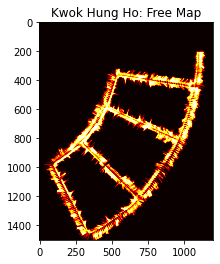

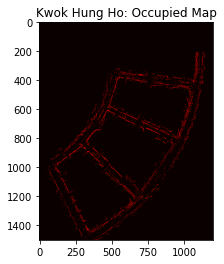

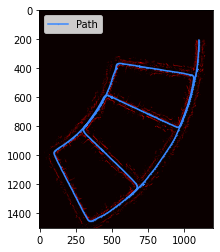

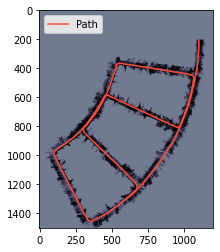

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


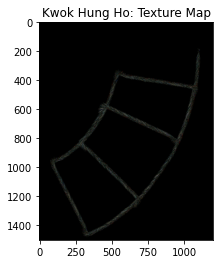

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


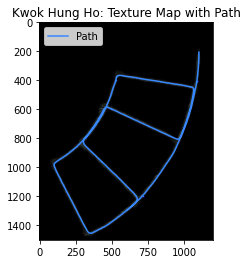

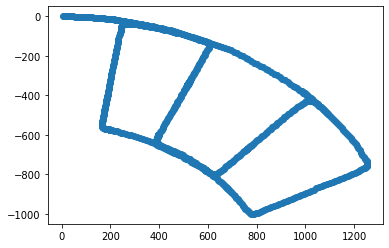

In [35]:
#Plot

occupied = slam.mapLogOdds.MAP['map'] = (slam.mapLogOdds.MAP['mapLogOdds'] > 0).astype(int)     
free = slam.mapLogOdds.MAP['map'] = (slam.mapLogOdds.MAP['mapLogOdds'] < 0).astype(int)   

fig1 = plt.figure()
plt.imshow(free,cmap="hot")
plt.title("Kwok Hung Ho: Free Map")
plt.savefig("Free.png", dpi=1200)
plt.show(block=True)   


fig1 = plt.figure()
plt.imshow(occupied,cmap="hot")
plt.title("Kwok Hung Ho: Occupied Map")
plt.savefig("occupied.png", dpi=1200)
plt.show(block=True)   



# Get path on top of occupancy map
predtmp = [[np.ceil(x-slam.mapLogOdds.MAP["ymin"]),np.ceil(y-slam.mapLogOdds.MAP["xmin"])] for y,x in pred]
fig, ax = plt.subplots()
ax.imshow(occupied, cmap="hot")
# ax.scatter( [x[0] for x in predtmp],[y[1] for y in predtmp],label="path")
ax.plot([x[0] for x in predtmp],[y[1] for y in predtmp], marker='o', color='#3888ff', ms=0.3, label="Path")
ax.legend(loc='upper left')
plt.savefig("occupied_and_path1.png", dpi=1200)
plt.show(block=True)

gamma = 1.0 - 1.0/(1.0 + np.exp(slam.mapLogOdds.MAP['mapLogOdds']))
fig, ax = plt.subplots()
ax.imshow(gamma, cmap="bone")
# ax.scatter( [x[0] for x in predtmp],[y[1] for y in predtmp],label="path")
ax.plot([x[0] for x in predtmp],[y[1] for y in predtmp], marker='o', color='#ff4733', ms=0.05, label="Path")
ax.legend(loc='upper left')
plt.savefig("occupied_and_path2.png",dpi=1200)
plt.show(block=True)

# fig1 = plt.figure()
# # draw path
# # pred.append((np.ceil(x_pred-slam.mapLogOdds.MAP["xmin"]), np.ceil(y_pred-slam.mapLogOdds.MAP["ymin"])))

# predtmp = [[np.ceil(x-slam.mapLogOdds.MAP["xmin"]),np.ceil(y-slam.mapLogOdds.MAP["ymin"])] for x,y in pred]
# predtmp = [[np.uint32(x),np.uint32(y)] for x,y in pred]

# occupiedWithContour = np.copy(occupied)
# # for x,y in pred:
# # predtmp = [np.array(pred)]
# # cv2.polylines(occupiedWithContour, pred, -1, (0,255,0), 3)
# cv2.polylines(np.float32(occupiedWithContour), [predtmp], False, (0,255,0), 3)

# plt.imshow(occupiedWithContour)
# plt.title("Kwok Hung Ho: Occupied Grid Map with trajectory")
# plt.show(block=True)   



fig1 = plt.figure()
plt.imshow( slam.mapLogOdds.MAP['texture'].astype(np.int8))
plt.title("Kwok Hung Ho: Texture Map")
plt.savefig("Texture.png",dpi=1200)
plt.show(block=True)   

fig, ax = plt.subplots()
ax.imshow( slam.mapLogOdds.MAP['texture'].astype(np.int8))
ax.plot([x[0] for x in predtmp],[y[1] for y in predtmp], marker='o', color='#3888ff', ms=0.05, label="Path")
ax.legend(loc='upper left')
plt.title("Kwok Hung Ho: Texture Map with Path")
plt.savefig("Texture_path.png",dpi=1200)
plt.show(block=True)   
   
# slam.mapLogOdds.MAP['map'] = (slam.mapLogOdds.MAP['mapLogOdds'] > 0).astype(int)  

# fig1 = plt.figure()
# plt.imshow(slam.mapLogOdds.MAP['map'],cmap="gray")
# plt.title("Occupancy grid map")
# plt.show(block=True)    

# fig1 = plt.figure()
# gamma = 1.0 - 1.0/(1.0 + np.exp(slam.mapLogOdds.MAP['mapLogOdds']))
# plt.imshow(gamma,cmap="gray")
# # plt.imshow(slam.mapLogOdds.MAP['map'],cmap="bone")
# plt.title("Occupancy grid map")
# plt.show(block=True)    

# fig1 = plt.figure()
# gamma = 1.0 - 1.0/(1.0 + np.exp(slam.mapLogOdds.MAP['mapLogOdds']))
# plt.imshow(gamma,cmap="bone")
# # plt.imshow(slam.mapLogOdds.MAP['map'],cmap="bone")
# plt.title("Occupancy grid map")
# plt.show(block=True)    

fig3 = plt.figure()
plt.scatter([x[0] for x in pred],[y[1] for y in pred] )
plt.title("Predicted path in World Frame")
plt.savefig("worldframepath.png",dpi=1200)
plt.show(block=True)
    
### save results as pickle